### Note:
This notebook is used to estimate the number of load from elbow's EMG signal. The EMG data were collected during the elbow flexion and extension experiment with different loads. During the experiment, three types of loads are measured which are 5.5lbs, 8.8lbs, and 11.1lbs.

In [ ]:
import os
import glob
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import imageio

import pandas as pd

%matplotlib inline

### Data preprocessing

In [3]:
# For load estimation

path = r'D:\GitHub\EMG_regressive_model\data\1'
all_files = glob.glob(path + "/*csv")
dfList = []

for filename in all_files:
    df = pd.read_csv(filename)
    df.head()
    dfList.append(df)
frame = pd.concat(dfList, axis = 1, ignore_index = False)
frame.head()

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,ch9,ch10,ch11,ch12,ch13,ch14,ch15,load
0,-0.084833,0.336391,0.727666,0.284861,0.157216,0.150551,0.299531,0.145583,-0.026877,0.055283,0.000155,-0.111373,0.082754,0.028478,-0.023124,5.5
1,-0.046846,0.289916,0.538304,0.174659,0.194968,0.062330,0.227172,0.090609,0.020410,0.020337,-0.002328,-0.095761,0.071228,0.015774,-0.012425,5.5
2,-0.047517,0.263150,0.574644,0.187919,0.198232,0.091427,0.166249,0.101292,0.029889,0.016017,-0.003360,-0.094898,0.071989,0.014139,-0.015784,5.5
3,-0.043622,0.259777,0.472857,0.145080,0.184822,0.000898,0.089452,0.083603,0.053789,-0.008042,-0.007052,-0.088583,0.062830,0.009523,-0.006107,5.5
4,-0.052821,0.249013,0.505147,0.149475,0.212153,0.056851,0.121410,0.111416,0.107618,-0.001524,-0.003577,-0.089234,0.066249,0.011462,-0.010132,5.5


<AxesSubplot:xlabel='load', ylabel='count'>

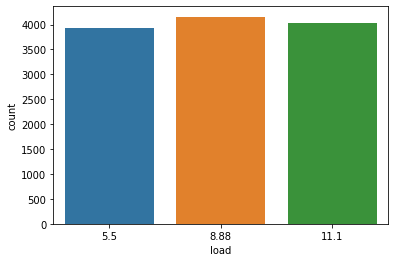

In [4]:
sns.countplot(x = 'load', data=frame)

In [6]:
# create input and output data
x = frame.iloc[:, 0:-1]
y = frame.iloc[:, -1]

# split the data into train, validate, and test set
# because there is a class imblance, should use the stratify opton to make each set has identical distribution
X_trainval, X_test, y_trainval, y_test = train_test_split(x, y)

X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1)

In [7]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

Text(0.5, 1.0, 'Class distribution in test set')

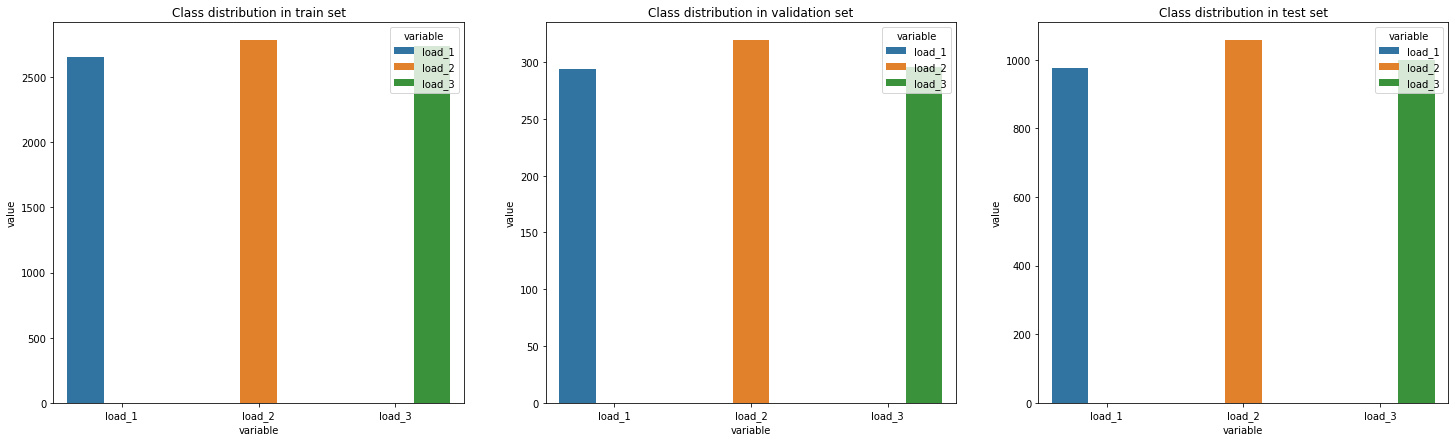

In [8]:
def get_load_distribution(obj):
    count_dict = {
        'load_1': 0,
        'load_2': 0,
        'load_3': 0,
    }
    for i in obj:
        if i == 5.5:
            count_dict['load_1'] += 1
        elif i == 8.88:
            count_dict['load_2'] += 1
        elif i == 11.1:
            count_dict['load_3'] += 1
        else:
            print('Check load labels')
    return count_dict
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (25, 7))

#Train
sns.barplot(data=
           pd.DataFrame.from_dict([get_load_distribution(y_train)]).melt(),
           x = 'variable',
           y = 'value',
           hue = 'variable',
           ax = axes[0]).set_title('Class distribution in train set')

#Validation
sns.barplot(data=
           pd.DataFrame.from_dict([get_load_distribution(y_val)]).melt(),
           x = 'variable',
           y = 'value',
           hue = 'variable',
           ax = axes[1]).set_title('Class distribution in validation set')

#Test
sns.barplot(data=
           pd.DataFrame.from_dict([get_load_distribution(y_test)]).melt(),
           x = 'variable',
           y = 'value',
           hue = 'variable',
           ax = axes[2]).set_title('Class distribution in test set')


In [9]:
y_train, y_test, y_val = y_train.astype(float), y_test.astype(float), y_val.astype(float)

### Setup the Neural Network

In [10]:
#Reproducible
torch.manual_seed(1)

### Check whether the GPU is available

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [12]:
class RegressionDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data
    
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return len(self.x_data)

In [13]:
train_dataset = RegressionDataset(torch.from_numpy(X_train).float(),
                                 torch.from_numpy(y_train).float())
test_dataset = RegressionDataset(torch.from_numpy(X_test).float(),
                                torch.from_numpy(y_test).float())
val_dataset = RegressionDataset(torch.from_numpy(X_val).float(),
                               torch.from_numpy(y_val).float())

### Build the feedforward neural network

In [14]:
class MultipleRegression(nn.Module):
    def __init__(self, num_features):
        super(MultipleRegression, self).__init__()
        self.fc1 = nn.Linear(num_features, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 1)
        
        self.relu = nn.ReLU()
    
    def forward(self, inputs):
        x = self.relu(self.fc1(inputs))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.output(x)
        
        return x
    
    def predict(self, test_inputs):
        x = self.relu(self.fc1(test_inputs))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.output(x)
        
        return x
        
        

In [15]:
EPOCHS = 150
BATCH_SIZE = 16
LEARNING_RATE = 0.001
NUM_FEATURES = len(x.columns)

In [16]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [17]:
model = MultipleRegression(NUM_FEATURES)
model.to(device)

print(model)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

MultipleRegression(
  (fc1): Linear(in_features=15, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)


In [18]:
# Define a dictionary which will store the loss / epoch for both train and validation sets
loss_stats = {
    'train':[],
    'val':[]
}

### Train the network

In [20]:
print('=========Begin Training=========')
for e in range(1, EPOCHS+1):
    
    #TRAINING
    train_epoch_loss = 0
    model.train()
    
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
    
    #VALIDATION
    with torch.no_grad():
        
        val_epoch_loss = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
            
            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))
            
            val_epoch_loss += val_loss.item()
            
    loss_stats['train'].append(train_epoch_loss / len(train_loader))
    loss_stats['val'].append(val_epoch_loss / len(val_loader))
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')
    
    

=========Begin Training=========
Epoch 001: | Train Loss: 0.00016 | Val Loss: 0.00152
Epoch 002: | Train Loss: 0.00041 | Val Loss: 0.00139
Epoch 003: | Train Loss: 0.00018 | Val Loss: 0.00259
Epoch 004: | Train Loss: 0.00075 | Val Loss: 0.00246
Epoch 005: | Train Loss: 0.00047 | Val Loss: 0.00665
Epoch 006: | Train Loss: 0.00078 | Val Loss: 0.00145
Epoch 007: | Train Loss: 0.00051 | Val Loss: 0.00185
Epoch 008: | Train Loss: 0.00031 | Val Loss: 0.00277
Epoch 009: | Train Loss: 0.00121 | Val Loss: 0.03233
Epoch 010: | Train Loss: 0.00638 | Val Loss: 0.00770
Epoch 011: | Train Loss: 0.00011 | Val Loss: 0.00222
Epoch 012: | Train Loss: 0.00010 | Val Loss: 0.00287
Epoch 013: | Train Loss: 0.00010 | Val Loss: 0.00363
Epoch 014: | Train Loss: 0.00027 | Val Loss: 0.00383
Epoch 015: | Train Loss: 0.00032 | Val Loss: 0.00371
Epoch 016: | Train Loss: 0.00126 | Val Loss: 0.00190
Epoch 017: | Train Loss: 0.00016 | Val Loss: 0.00362
Epoch 018: | Train Loss: 0.00011 | Val Loss: 0.00349
Epoch 019: | 

### Post processing
1. Vsiualize loss and accuracy
2. Test trained model

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

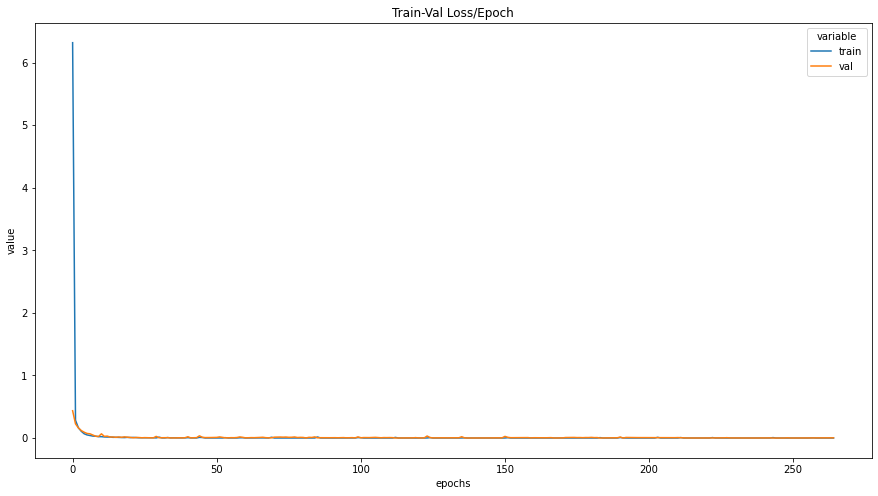

In [22]:
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
plt.figure(figsize=(15,8))
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Train-Val Loss/Epoch')

In [23]:
y_pred_list = []

with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_list.append(y_test_pred.cpu().numpy())

In [24]:
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [25]:
mse = mean_squared_error(y_test, y_pred_list)
r_square = r2_score(y_test, y_pred_list)

print("Mean Squared Error :",mse)
print("R^2 :",r_square)

Mean Squared Error : 0.0006865468554288525
R^2 : 0.9998673104370672
